# Neural Network Implementation
![three_layer_neural_network_e50fa950bc.webp](attachment:6b5f663e-c38c-4071-8b69-bc3bcb064f13.webp)

In [1]:
# Fix OpenMP conflict (important for Windows)
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

## Custom Neural Network Architecture

In [ ]:
# Creating a model
class Model(nn.Module):
    #Layering the model
    def __init__(self,in_features=784,h1=256,h2=128,out_features=10):
        super().__init__() #instantiate our nn.Module
        self.flatten = nn.Flatten()
        self.fc1= nn.Linear(in_features,h1)
        self.fc2= nn.Linear(h1,h2)
        self.out= nn.Linear(h2,out_features)
        #Intializing the weights
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.out.weight)
    #Feedforwarding "Forward propagation"
    def forward(self,x):
        #Convert tensor shapes into [64,1,28,28] into [64,784]
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)

        return x



## Training Infrastructure

## 1-Preparing and loading the MNIST dataset

In [ ]:
#Converts MNIST images (28×28 grayscale) into PyTorch tensors
transform = transforms.Compose([transforms.ToTensor()])
#Loading the training dataset
training_dataset = torchvision.datasets.MNIST(
    root="Data",
    download=True,
    train=True,
    transform=transform
)

training_loader = torch.utils.data.DataLoader(
    training_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0
)
#Loading the testing dataset
test_dataset = torchvision.datasets.MNIST(
    root="Data",
    train=False,
    download=True,
    transform=transform
)


test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

img, label = training_dataset[0]
print("Tensor shape:", img.shape)
print("Label:", label)


Tensor shape: torch.Size([1, 28, 28])
Label: 5


## Training the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)  # Move the model to the device "GPU if exists" or "CPU"
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
EPOCHS = 10     # 10 full passes through the dataset

#Lists needed for the plotting which is collecting the values of losses and accuracies each EPOCH
train_losses = []
val_losses = []
train_std = []
val_std = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    model.train()

    batch_train_losses = []  # store batch losses for this epoch

    # Training the model
    for batch_idx, (inputs, labels) in enumerate(training_loader):
        # Moving data to mainly the GPU since we are rendering images
        inputs, labels = inputs.to(device), labels.to(device).long()

        # Reset gradients from previous batch
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Computing how wrong the predictions are by calculating the loss
        loss = loss_fn(outputs, labels)

        # Calculating the weights by backpropagation
        loss.backward()

        # Updating the new weights
        optimizer.step()

        running_loss += loss.item()
        batch_train_losses.append(loss.item())

        # Compute training accuracy , _ part means we dont need the other parameter
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Monitor the progress after 100 batches
        if (batch_idx + 1) % 100 == 0:
            avg_loss = running_loss / 100
            print(f"  Batch {batch_idx+1:4d}  |  Loss: {avg_loss:.4f}")
            running_loss = 0.0

    # Average training metrics for the epoch
    avg_train_loss = np.mean(batch_train_losses)
    train_losses.append(avg_train_loss)
    train_std.append(np.std(batch_train_losses))
    train_acc = 100 * correct_train / total_train
    train_accuracies.append(train_acc)

    # Evaluating the model
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    batch_val_losses = []  # store batch losses for this epoch

    with torch.no_grad():              #disable the gradients "self explanatory"
        for vinputs, vlabels in test_loader:
            vinputs, vlabels = vinputs.to(device), vlabels.to(device).long()
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            val_loss += vloss.item()
            batch_val_losses.append(vloss.item())

            _, predicted = torch.max(voutputs, 1)
            total_val += vlabels.size(0)
            correct_val += (predicted == vlabels).sum().item()

    avg_vloss = np.mean(batch_val_losses)
    val_losses.append(avg_vloss)
    val_std.append(np.std(batch_val_losses))
    val_acc = 100 * correct_val / total_val
    val_accuracies.append(val_acc)

    print(f"Training Accuracy: {train_acc:.2f}%  |  Validation Loss: {avg_vloss:.4f}  |  Accuracy: {val_acc:.2f}%")


Epoch 1/10
  Batch  100  |  Loss: 0.9497
  Batch  200  |  Loss: 0.3601
  Batch  300  |  Loss: 0.3203
  Batch  400  |  Loss: 0.2727
  Batch  500  |  Loss: 0.2576
  Batch  600  |  Loss: 0.2395
  Batch  700  |  Loss: 0.2428
  Batch  800  |  Loss: 0.1878
  Batch  900  |  Loss: 0.1989
Training Accuracy: 90.39%  |  Validation Loss: 0.1664  |  Accuracy: 95.08%

Epoch 2/10
  Batch  100  |  Loss: 0.1575
  Batch  200  |  Loss: 0.1459
  Batch  300  |  Loss: 0.1365
  Batch  400  |  Loss: 0.1444
  Batch  500  |  Loss: 0.1486
  Batch  600  |  Loss: 0.1399
  Batch  700  |  Loss: 0.1352
  Batch  800  |  Loss: 0.1182
  Batch  900  |  Loss: 0.1208
Training Accuracy: 95.83%  |  Validation Loss: 0.1132  |  Accuracy: 96.45%

Epoch 3/10
  Batch  100  |  Loss: 0.1057
  Batch  200  |  Loss: 0.1030
  Batch  300  |  Loss: 0.0885
  Batch  400  |  Loss: 0.0913
  Batch  500  |  Loss: 0.0895
  Batch  600  |  Loss: 0.0956
  Batch  700  |  Loss: 0.0916
  Batch  800  |  Loss: 0.0921
  Batch  900  |  Loss: 0.0936
Trai

## Plotting Part

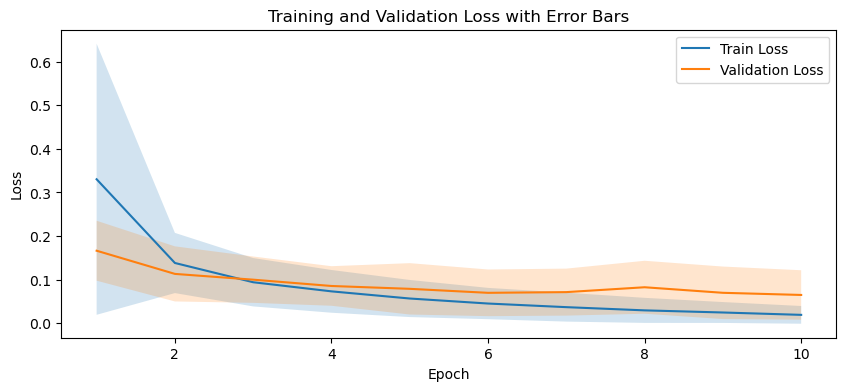

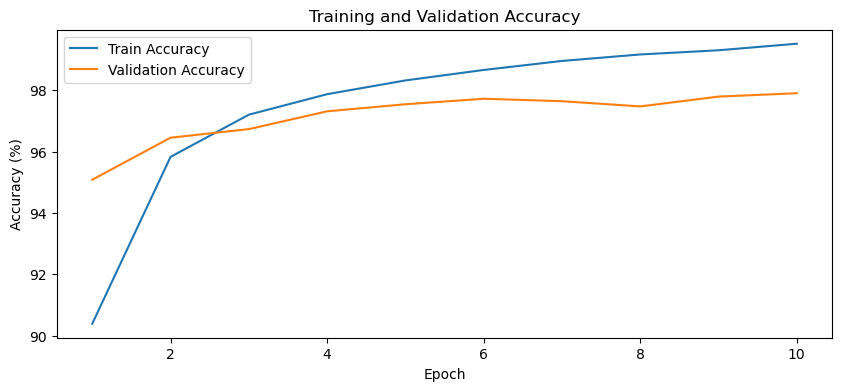

In [ ]:
epochs_range = range(1, EPOCHS+1)

# Loss plot
plt.figure(figsize=(10,4))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.fill_between(epochs_range,
                 np.array(train_losses)-np.array(train_std),
                 np.array(train_losses)+np.array(train_std), alpha=0.2)
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.fill_between(epochs_range,
                 np.array(val_losses)-np.array(val_std),
                 np.array(val_losses)+np.array(val_std), alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss with Error Bars')
plt.legend()
plt.show()

# Accuracy plot
plt.figure(figsize=(10,4))
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
